In [1]:
%matplotlib inline

import operator
import imblearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from collections import defaultdict
from itertools import cycle, islice
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, roc_curve, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from autoviz.AutoViz_Class import AutoViz_Class
from autoviml.Auto_ViML import Auto_ViML
import shap
shap.initjs()

Imported AutoViz_Class. Call by using AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)


In [55]:
df = pd.read_csv('data/original_watson_dataset.csv')
df.MonthlyIncome.describe()

count     1470.000000
mean      6502.931293
std       4707.956783
min       1009.000000
25%       2911.000000
50%       4919.000000
75%       8379.000000
max      19999.000000
Name: MonthlyIncome, dtype: float64

In [53]:
df.JobRole.value_counts()

Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: JobRole, dtype: int64

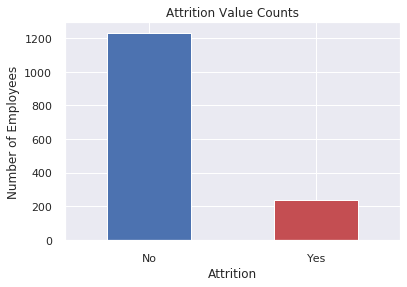

In [167]:
attrition_count = df.Attrition.value_counts()
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
ax = attrition_count.plot.bar(color=my_colors)
plt.title('Attrition Value Counts')
plt.xlabel('Attrition')
plt.ylabel('Number of Employees')
ax.set_xticklabels(['No', 'Yes'],rotation = 0);

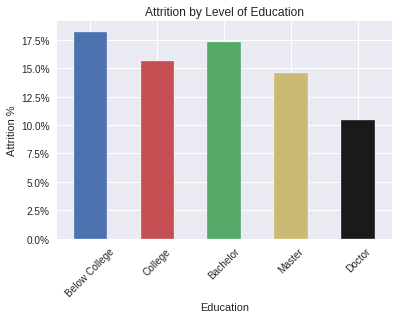

In [19]:
df. Attrition = df.Attrition\
.replace('Yes', 1)\
.replace('No', 0)
ed_info = df.groupby('Education', as_index=False).agg({'Attrition':'sum',
                                                      'EmployeeCount':'count'})
ed_info['AttrRatio'] = ed_info.Attrition/ed_info.EmployeeCount

my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
ax = ed_info.AttrRatio.plot.bar(color=my_colors)
plt.title('Attrition by Level of Education')
plt.xlabel('Education')
plt.ylabel('Attrition %')
edulabels = ('Below College', 'College', 'Bachelor', 'Master', 'Doctor')
ax.set_xticklabels(edulabels, rotation = 45)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals]);

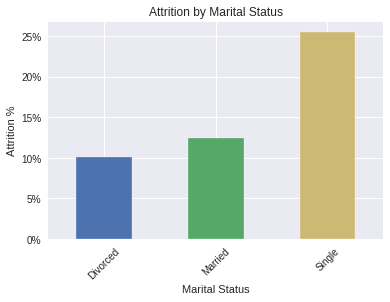

In [17]:
df. Attrition = df.Attrition\
.replace('Yes', 1)\
.replace('No', 0)
mar_info = df.groupby('MaritalStatus', as_index=False).agg({'Attrition':'sum',
                                                      'EmployeeCount':'count'})
mar_info['AttrRatio'] = mar_info.Attrition/mar_info.EmployeeCount
my_colors = list(islice(cycle(['b', 'g', 'y', 'k']), None, len(df)))
ax = mar_info.AttrRatio.plot.bar(color=my_colors)
plt.title('Attrition by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Attrition %')
marlabels = ('Divorced', 'Married', 'Single')
ax.set_xticklabels(marlabels, rotation = 45)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);

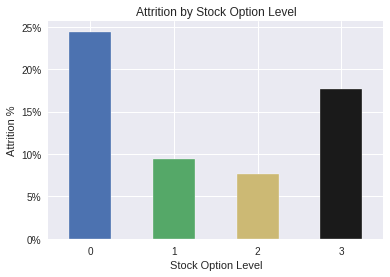

In [18]:
df. Attrition = df.Attrition\
.replace('Yes', 1)\
.replace('No', 0)
stock_info = df.groupby('StockOptionLevel', as_index=False).agg({'Attrition':'sum',
                                                      'EmployeeCount':'count'})
stock_info['AttrRatio'] = stock_info.Attrition/stock_info.EmployeeCount
stock_info
my_colors = list(islice(cycle(['b', 'g', 'y', 'k']), None, len(df)))
ax = stock_info.AttrRatio.plot.bar(color=my_colors)
plt.title('Attrition by Stock Option Level')
plt.xlabel('Stock Option Level')
plt.ylabel('Attrition %')
ax.set_xticklabels([0,1,2,3], rotation = 0)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);

In [23]:
# feature engineering
df = df.iloc[:,1:].drop(['MonthlyRate', 'HourlyRate', 'EmployeeNumber',
                         'EmployeeCount', 'Gender', 'Over18', 'StandardHours'], axis=1)
df['ResearchTravelRare'] = ((df.BusinessTravel == 'Travel_Rarely') & (df.Department == 'Research & Development'))\
.astype(int)
df['YearsNoChange'] = df[["YearsInCurrentRole", "YearsSinceLastPromotion", 'YearsWithCurrManager']].min(axis=1)

In [327]:
df_engi = df.copy(deep=True)
df_engi.OverTime = df_engi.OverTime.replace('Yes', 1)\
.replace('No', 0)
df_engi.MaritalStatus = df_engi.MaritalStatus.replace('Married', 2)\
.replace('Single', 1)\
.replace('Divorced', 0)
df_engi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 26 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EnvironmentSatisfaction     1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null int64
OverTime                    1470 non-null int64
PercentSalaryHike           1470 non-null int64
PerformanceRating           1470 non-null int64
RelationshipSatisfaction    1470 non-null int64
StockOptionLevel        

In [328]:
department_df = df_engi.groupby(['Department'], as_index=False).agg({'Age':'mean',
                                                                'DistanceFromHome':'mean',
                                                                'Education':'mean',
                                                                'EnvironmentSatisfaction': 'mean',
                                                                'JobInvolvement': 'mean',
                                                                'MaritalStatus': 'mean',
                                                                'OverTime': 'mean',
                                                                'RelationshipSatisfaction': 'mean',
                                                                'StockOptionLevel': 'mean',
                                                                'TotalWorkingYears': 'mean',
                                                                'WorkLifeBalance':'mean',
                                                               })
dept_col = ['Dept_' + col for col in department_df.iloc[:,1:].columns]
department_df.columns = ['Department'] + dept_col
department_df.head()

,Department,Dept_Age,Dept_DistanceFromHome,Dept_Education,Dept_EnvironmentSatisfaction,Dept_JobInvolvement,Dept_MaritalStatus,Dept_OverTime,Dept_RelationshipSatisfaction,Dept_StockOptionLevel,Dept_TotalWorkingYears,Dept_WorkLifeBalance
0,Human Resources,37.809524,8.698413,2.968254,2.682540,2.746032,1.285714,0.269841,2.888889,0.777778,11.555556,2.920635
1,Research & Development,37.042664,9.144641,2.899063,2.744017,2.741935,1.217482,0.281998,2.708637,0.804370,11.342352,2.725286
2,Sales,36.542601,9.365471,2.934978,2.679372,2.701794,1.266816,0.286996,2.695067,0.773543,11.105381,2.816143


In [329]:
level_df = df_engi.groupby(['JobLevel'], as_index=False).agg({   'Age':'mean',
                                                            'DistanceFromHome':'mean',
                                                            'Education':'mean',
                                                            'EnvironmentSatisfaction': 'mean',
                                                            'JobInvolvement': 'mean',
                                                            'MaritalStatus': 'mean',
                                                            'OverTime': 'mean',
                                                            'RelationshipSatisfaction': 'mean',
                                                            'StockOptionLevel': 'mean',
                                                            'TotalWorkingYears': 'mean',
                                                            'WorkLifeBalance':'mean',
                                                               })
level_col = ['Lvl_' + col for col in level_df.iloc[:,1:].columns]
level_df.columns = ['JobLevel'] + level_col
level_df.head()

,JobLevel,Lvl_Age,Lvl_DistanceFromHome,Lvl_Education,Lvl_EnvironmentSatisfaction,Lvl_JobInvolvement,Lvl_MaritalStatus,Lvl_OverTime,Lvl_RelationshipSatisfaction,Lvl_StockOptionLevel,Lvl_TotalWorkingYears,Lvl_WorkLifeBalance
0,1,32.524862,8.631676,2.751381,2.718232,2.744015,1.226519,0.287293,2.721915,0.745856,5.891344,2.714549
1,2,36.599251,9.683521,2.985019,2.739700,2.730337,1.241573,0.273408,2.674157,0.838951,10.423221,2.790262
2,3,40.087156,9.770642,3.013761,2.660550,2.669725,1.201835,0.288991,2.688073,0.825688,15.119266,2.793578
3,4,47.537736,10.226415,3.122642,2.754717,2.820755,1.311321,0.311321,2.830189,0.783019,25.471698,2.735849
4,5,47.753623,6.391304,2.985507,2.753623,2.666667,1.246377,0.260870,2.826087,0.739130,26.376812,2.840580


In [330]:
df_engi = df_engi.merge(department_df, on='Department')
df_engi = df_engi.merge(level_df, on='JobLevel')
ratio_cols = ['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 
              'MaritalStatus', 'OverTime', 'RelationshipSatisfaction', 'StockOptionLevel', 
              'TotalWorkingYears', 'WorkLifeBalance']
for col in ratio_cols:
    df_engi['Dept' + col + 'Ratio'] = df_engi[col]/df_engi['Dept_' + col]
    df_engi['Lvl' + col + 'Ratio'] = df_engi[col]/df_engi['Lvl_' + col]
df_engi = df_engi.drop(level_col+dept_col, axis=1)

In [61]:
# define manual train and test division
# df. Attrition = df.Attrition\
# .replace('Yes', 1)\
# .replace('No', 0)
test_sample = df.sample(int(df.shape[0] * .20), random_state=99)
train, test = df[~df.isin(test_sample)].dropna(), df[df.isin(test_sample)].dropna()
train_dum = pd.get_dummies(train, dtype=int)
test_dum = pd.get_dummies(test, dtype=int)

Train (Size: 1176,31) has Single_Label with target: ['Attrition']
"
 ################### Binary-Class ##################### " 
Shuffling the data set before training
 Class  -> Counts -> Percent
    No:     991  ->   84.3%
   Yes:     185  ->   15.7%
Selecting 2-Class Classifier...
    Using GridSearchCV for Hyper Parameter tuning...
String or Multi Class target: Attrition transformed as follows: {'Yes': 0, 'No': 1}
Classifying variables in data set...
    Number of Numeric Columns =  10
    Number of Integer-Categorical Columns =  0
    Number of String-Categorical Columns =  17
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  1
    Number of Numeric-Boolean Columns =  2
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  0
    Number of Columns to Delete =  0
    30 Predictors classified...
        This does not include the Target column(s)
    No variabl

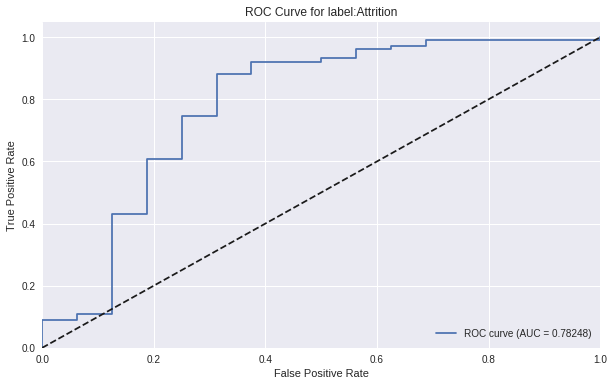

Average precision-recall score: 0.94
Macro F1 score, averaged over all classes: 0.69


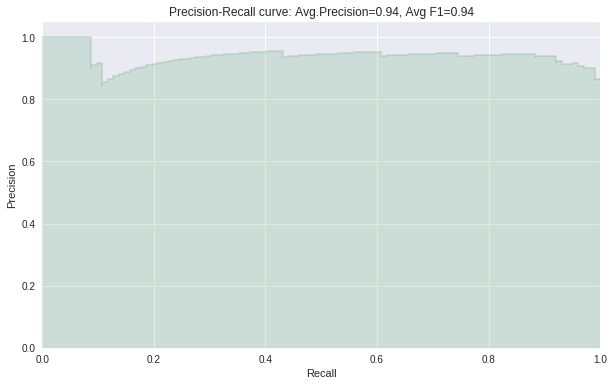

After multiple models, Ensemble Model Results:
    Balanced Accuracy Score = 89.831%
              precision    recall  f1-score   support

           0       0.83      0.31      0.45        16
           1       0.90      0.99      0.94       102

    accuracy                           0.90       118
   macro avg       0.87      0.65      0.70       118
weighted avg       0.89      0.90      0.88       118

[[  5  11]
 [  1 101]]

Single Model is better than Ensembling Models for this data set.
Could not plot Cross Validation Parameters
    Time taken for this Target (in seconds) = 8
Plotting Feature Importances to explain the output of model

###################################################################################
Training model on complete Train data and Predicting using give Test Data...
Leaving Top 6 continuous variables as is...
    No Entropy Binning specified
Number of numeric variables = 6
    No variables were removed since no highly correlated variables found in d

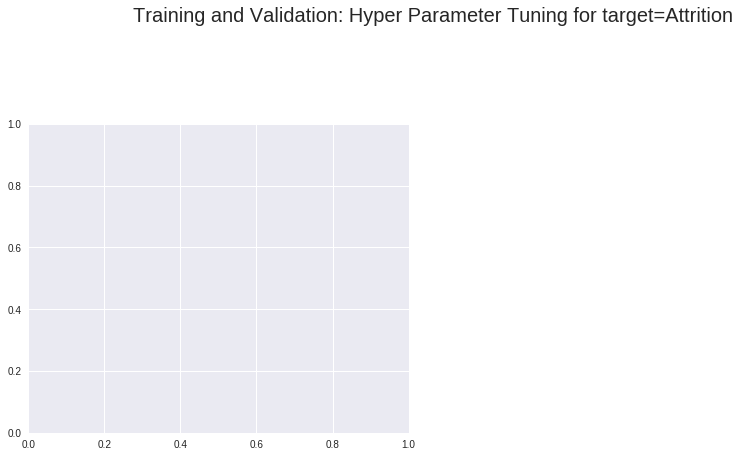

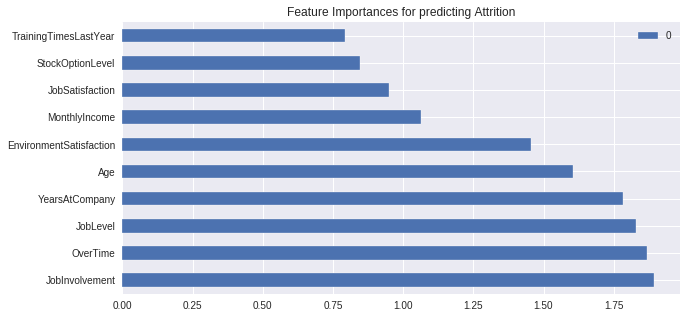

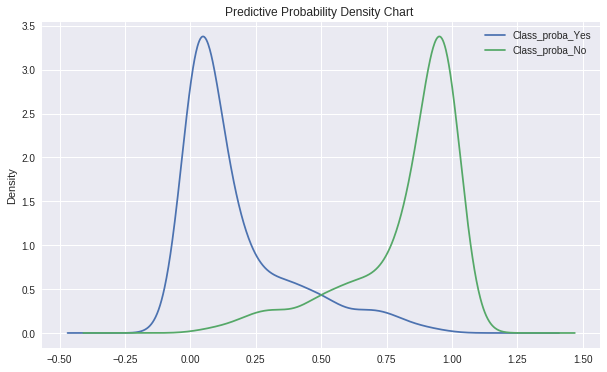

In [62]:
# train_dum = pd.get_dummies(train)
model_f1, features_f1, trainm_f1, testm_f1 = Auto_ViML(train, 'Attrition', test, verbose=2, scoring_parameter='weighted_f1')

In [25]:
remove = [item for item in list(df.columns) if item not in features_f1]
remove

['Attrition',
 'MonthlyIncome',
 'TotalWorkingYears',
 'YearsAtCompany',
 'YearsWithCurrManager',
 'CompaRatio']

In [404]:
model_f1

LogisticRegression(C=20.41795918367347, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=3000, multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=99, solver='lbfgs', tol=0.0001, verbose=False,
                   warm_start=False)

In [28]:
# take features with autoviml feature selection
remove = ['Attrition', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'YearsWithCurrManager']
features = df.drop(remove, axis=1)
features_dum = pd.get_dummies(features)
target = df.Attrition\
.replace('Yes', 1)\
.replace('No', 0)

X_train, X_test, y_train, y_test = train_test_split(features_dum, target, 
                                                    test_size = 0.2, random_state=99)

In [48]:
# create models
log = LogisticRegression(C=20, solver='lbfgs', max_iter=3000, n_jobs=-1, class_weight={1 : 1, 0 : 1})
forest = RandomForestClassifier(n_estimators=200, max_features='sqrt')
gnb = GaussianNB()
svc = SVC(kernel='poly', degree=2)
lda = LinearDiscriminantAnalysis()
bag = BaggingClassifier(DecisionTreeClassifier())

xgbm = xgb.XGBClassifier(seed=99,n_jobs=-1, random_state=99,
                                     objective='binary:logistic')

In [78]:
attrib = features_dum

n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos * 3, 0 : n_neg} 

smote = imblearn.over_sampling.SMOTE(ratio=ratio, random_state = 99)
model = log

pipeline = make_pipeline(smote, model)
stkf = StratifiedKFold(n_splits=5)
print('F1 Weighted:', np.mean(cross_val_score(pipeline, attrib, target, cv=stkf, scoring='f1_weighted')))
print('ROC-AUC:', np.mean(cross_val_score(pipeline, attrib, target, cv=stkf, scoring='roc_auc')))

F1 Weighted: 0.8662908672665071
ROC-AUC: 0.839944005456938


In [79]:
model = log
attrib = features_dum

print('F1 Weighted:', np.mean(cross_val_score(model, attrib, target, cv=kf, scoring='f1_weighted')))
print('Precision:', np.mean(cross_val_score(model, attrib, target, cv=kf, scoring='precision')))
print('Recall:', np.mean(cross_val_score(model, attrib, target, cv=kf, scoring='recall')))
print('ROC-AUC:', np.mean(cross_val_score(model, attrib, target, cv=kf, scoring='roc_auc')))

F1 Weighted: 0.8655055065869852
Precision: 0.720835194375517
Recall: 0.41845935940049445
ROC-AUC: 0.8402680146706271


In [49]:
kf = KFold(n_splits=5, random_state=99)
model = log
attrib = features_dum

print('F1 Weighted:', np.mean(cross_val_score(model, attrib, target, cv=kf, scoring='f1_weighted')))
print('Precision:', np.mean(cross_val_score(model, attrib, target, cv=kf, scoring='precision')))
print('Recall:', np.mean(cross_val_score(model, attrib, target, cv=kf, scoring='recall')))
print('ROC-AUC:', np.mean(cross_val_score(model, attrib, target, cv=kf, scoring='roc_auc')))

F1 Weighted: 0.8655055065869852
Precision: 0.720835194375517
Recall: 0.41845935940049445
ROC-AUC: 0.8402680146706271


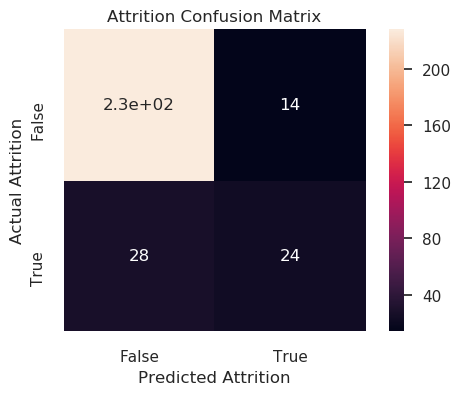

In [50]:
predict = log.fit(X_train,y_train).predict(X_test)
confusion = confusion_matrix(y_test, predict)
plt.figure(dpi=100)
sns.heatmap(confusion[::-1], annot=True, square=True, 
            xticklabels = ['False', 'True'], yticklabels=['True', 'False'])
plt.xlabel('Predicted Attrition')
plt.ylabel('Actual Attrition')
plt.ylim((0,2))
plt.title('Attrition Confusion Matrix');

Logistic Regression Model best F1 score 0.600 at prob decision threshold >= 0.283


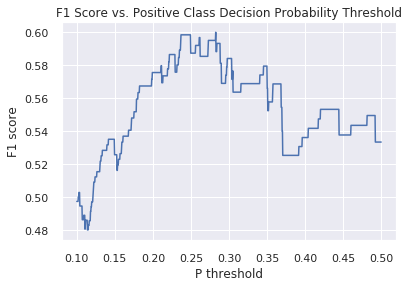

In [51]:
sns.set()

thresh_ps = np.linspace(.10,.50,1000)
model_val_probs = log.fit(X_train,y_train).predict_proba(X_test)[:,1] # positive class probs, same basic logistic model we fit in section 2 

f1_scores = []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_test, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('F1 score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

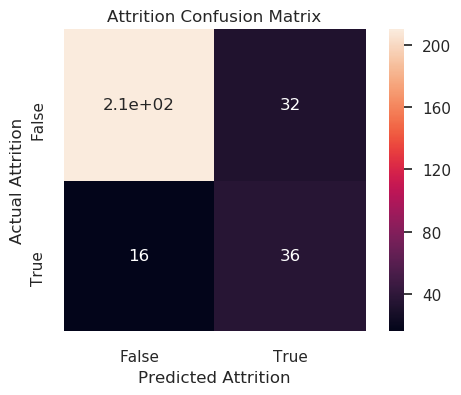

In [52]:
pred_thres = model_val_probs >= best_thresh_p
confusion2 = confusion_matrix(y_test, pred_thres)
plt.figure(dpi=100)
sns.heatmap(confusion2[::-1], annot=True, square=True, 
            xticklabels = ['False', 'True'], yticklabels=['True', 'False'])
plt.xlabel('Predicted Attrition')
plt.ylabel('Actual Attrition')
plt.ylim((0,2))
plt.title('Attrition Confusion Matrix');

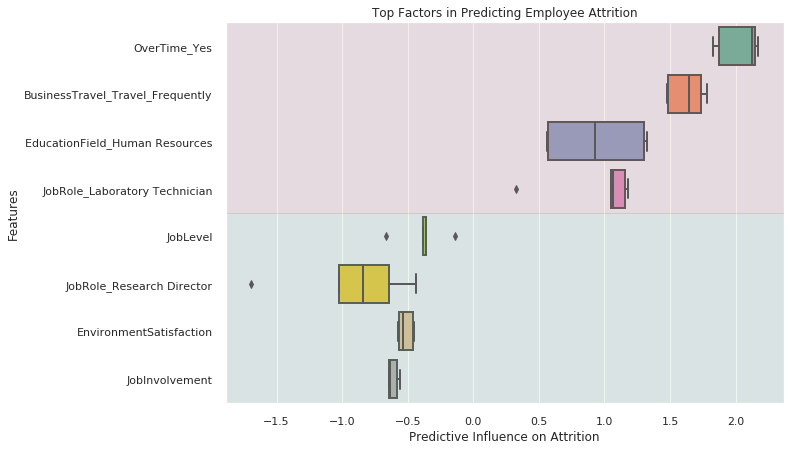

In [44]:
# plot feature coefficient variance
cv_results = cross_validate(log, X_train, y_train, cv=5, return_estimator=True)

feat_coef = []
for model in cv_results['estimator']:
    feat_coef.append(list(zip(X_train.columns, model.coef_[0])))
flat_feat = [item for sublist in feat_coef for item in sublist]

d = defaultdict(list)
for k, v in flat_feat:
    d[k].append(v)
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
x = ([feat[0] for feat in sorted_d[:2]]
     + [feat[0] for feat in sorted_d[4:6]]
    + [feat[0] for feat in sorted_d[-4:]])
y = ([coef[1] for coef in sorted_d[:2]]
    + [coef[1] for coef in sorted_d[4:6]]
    + [coef[1] for coef in sorted_d[-4:]])

labels = ['Overtime', 'Sales Dept', 'Single', 'HR Role', 'Life Sciences Ed.',
          'Env. Satisfaction', 'Job Involvement', 'Manager Role']
plt.figure(figsize=(10, 7))
ax = sns.boxplot(y,x, linewidth=2, palette='Set2')
# ax.set_xticklabels(labels)
# ax.axhline(3.5, ls='--', c='r')
ax.axhspan(ymin=3.5, ymax=7.5,color='g', alpha=0.1)
ax.axhspan(ymin=-0.5, ymax=3.5,color='r', alpha=0.1)
plt.title('Top Factors in Predicting Employee Attrition')
plt.xlabel('Predictive Influence on Attrition')
plt.ylabel('Features');